<a href="https://colab.research.google.com/github/Mochismo/LearnPython/blob/main/Preprocessing_Object_Detection_and_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 30 14:46:20 2020

@author: scholar1
"""
import os
import sys
import numpy as np
import math
import cv2
import pickle

# scale image initially so that crop_size covers the target feature well
scale_ratio = 0.25 # this should be 1/3?

control_point_offset = np.array([[0.05, 0, 0], [-0.05, 0, 0], [0, 0.05, 0], [0, -0.05, 0], [0, 0, 0.05], [0, 0, -0.05]])

def generate_output_directories(output_dir, num_data):
	if os.path.exists(output_dir) == False:
		os.mkdir(output_dir)

	for i in range(num_data):
		part_dir = os.path.join(output_dir, str(i))
		if os.path.exists(part_dir) == False:
			os.mkdir(part_dir)
            
    #marker points for backgound (refference or zero point)
	background_dir = os.path.join(output_dir, "background")
	if os.path.exists(background_dir) == False:
		os.mkdir(background_dir)

	for i in range(num_data):
		part_dir = os.path.join(output_dir, "64x64_" + str(i))
		if os.path.exists(part_dir) == False:
			os.mkdir(part_dir)


def read_poses(path_to_data):
	file_name = os.path.join(data_dir, "poseGT.txt")

	f = open(file_name, 'r')

	dict = {}

	with f as open_file_object:
		for line in open_file_object:
			elements = line.split()
			floats = [float(x) for x in elements[1:]]
			dict[elements[0]] = floats

	return dict

def read_point_file(file_path):
	points = []
	with open(file_path) as f:
		content = f.readlines()

		for line in content:
			elements = line.split()
			points.append([float(x) for x in elements])
        
	return points
       
def clamp(x, min_val, max_val):
	return min(max(x, min_val), max_val)

def difference_of_Gaussians(img):
	#run a 5x5 gaussian blur then a 3x3 gaussian blr
	kernel1 = cv2.getGaussianKernel(10, 1)
	kernel2 = cv2.getGaussianKernel(10, 3)

	dog_img = cv2.sepFilter2D(img, -1, kernel1 - kernel2, kernel1 - kernel2)
	dog_img = cv2.normalize(dog_img, dog_img, alpha = 0, beta = 255, norm_type=cv2.NORM_MINMAX)

	return dog_img


def output_cropped_image(x, y, img, output_path, crop_size, apply_dog = False):
	half_crop_size = int(crop_size / 2)
	x_min = x - half_crop_size
	x_max = x + half_crop_size
	y_min = y - half_crop_size
	y_max = y + half_crop_size
	if x_min < 0 or x_max >= np.size(img,1) or y_min < 0 or y_max >= np.size(img,0):
		return False

	crop = img[y_min:y_max, x_min:x_max]
	if apply_dog:
		crop = difference_of_Gaussians(crop)

	if crop.shape != (crop_size, crop_size):
		print("crop.shape", crop.shape, " something is wrong..")
		print(x_min, x_max, y_min, y_max)
		sys.exit(1)

	cv2.imwrite(output_path, crop)

	return True

def write_part_detection_training_img(img, i, annotation_projected_points, data_id, output_dir):
	crop_size = 32

	for j in range(len(annotation_projected_points)):
		projected_point = (annotation_projected_points[j] * scale_ratio).astype(int)
		#print(annotation_projected_points[j], projected_point)
		output_path = os.path.join(output_dir, str(j), str(data_id) + "_" + str(i).zfill(5) + ".png")
		output_cropped_image(projected_point[0][0], projected_point[0][1], img, output_path, crop_size, True)

	# generate background example
	while True:
		half_crop_size = int(crop_size / 2)
		x = np.random.randint(half_crop_size, np.size(img,1)-half_crop_size)
		y = np.random.randint(half_crop_size, np.size(img,0)-half_crop_size)
		close_to_annotated_points = False
		for j in range(len(annotation_projected_points)):
			projected_point = (annotation_projected_points[j] * scale_ratio).astype(int)
			if abs(x - projected_point[0][0]) <= half_crop_size or abs(y - projected_point[0][1]) <= half_crop_size:
				close_to_annotated_points = True
				break

		if close_to_annotated_points == False:
			# region not containing any annotated part is found
			output_path = os.path.join(output_dir, "background", str(data_id) + "_" + str(i).zfill(5) + ".png")
			output_cropped_image(x, y, img, output_path, crop_size, True)
			break

def write_control_points_detection_training_img(img, i, annotation_projected_points, data_id, output_dir):
	crop_size = 64
	is_cropped_image_saved = []

	for j in range(len(annotation_projected_points)):
		projected_point = (annotation_projected_points[j] * scale_ratio).astype(int)
		#print(annotation_projected_points[j], projected_point)
		output_path = os.path.join(output_dir, "64x64_" + str(j), str(data_id) + "_" + str(i).zfill(5) + ".png")
		success = output_cropped_image(projected_point[0][0], projected_point[0][1], img, output_path, crop_size)
		is_cropped_image_saved.append(success)

	return is_cropped_image_saved


def extract_images(data_id, data_dir, output_dir, all_projected_control_points):
	visualization = False


    
	path_to_data = os.path.join(data_dir, "frame0000" + str(data_id))
    #

	if visualization == True:
		marker_3d_points = np.array(read_point_file(os.path.join(path_to_data, "markers3dPoints.txt")))
		marker_3d_points.reshape(-1, 3)

	control_points_for_all_parts = []
	for annotation_pt in annotation_3d_points:
		control_pts_for_part = []
		for offset in control_point_offset:
			control_pts_for_part.append(annotation_pt + offset)
		
		control_points_for_all_parts.append(control_pts_for_part)

	control_points_for_all_parts = np.array(control_points_for_all_parts)
	#assert control_points_for_all_parts.shape == (4, 6, 3)

   

	Rts = read_poses(path_to_data)
	camera_matrix = np.float32([[2666.67, 0, 960], [0, 2666.67, 540], [0, 0, 1.]])
    

	#index = 0

	for i in range(0, len(Rts)):
		file_name = "frame" + str(i).zfill(5) + ".png"
		img_path = os.path.join(data_dir, file_name)
		img = cv2.imread(img_path)
		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
		img = cv2.resize(img, None, fx=scale_ratio, fy=scale_ratio, interpolation=cv2.INTER_AREA) 
        

		Rt = Rts[file_name]

		if math.isnan(Rt[0]) == True:
			continue

		annotation_projected_points, jac = cv2.projectPoints(annotation_3d_points, np.array(Rt[0:3]), np.array(Rt[3:6]), camera_matrix, np.float32([[0, 0, 0, 0, 0]]))
#		assert annotation_projected_points.shape == (4, 1, 2)
        
		write_part_detection_training_img(img, i, annotation_projected_points, data_id, output_dir)

		is_cropped_image_saved = write_control_points_detection_training_img(img, i, annotation_projected_points, data_id, output_dir)

		for j in range(control_points_for_all_parts.shape[0]):
			if is_cropped_image_saved[j] == False:
				continue

			projected_control_points_for_part, jac = cv2.projectPoints(control_points_for_all_parts[j], np.array(Rt[0:3]), np.array(Rt[3:6]), camera_matrix, np.float32([[0, 0, 0, 0, 0]]))
           # assert projected_control_points_for_part.shape == (6, 1, 2)

			# set relative offset from annotation_projected_points[j] here
			all_projected_control_points[j].append(projected_control_points_for_part - annotation_projected_points[j])

		# debug
		if visualization:
			color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
			for part_id, projected_control_points_for_part in enumerate(all_projected_control_points):
				for idx, point in enumerate(projected_control_points_for_part[-1]):
					color_code = idx % 6
					color = (0, 0, 255)
					if color_code == 2 or color_code == 3:
						color = (0, 255, 0)
					if color_code == 4 or color_code == 5:
						color = (255, 0, 0)

					point = (annotation_projected_points[part_id] + point) * scale_ratio
					cv2.circle(color_img, (int(point[0][0]), int(point[0][1])), 5, color, 1)

				cv2.putText(color_img, str(part_id), (int(point[0][0]), int(point[0][1])),
							cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

			cv2.imwrite(os.path.join("debug", str(i) + ".png"), color_img)

		if i%100 == 0:
			print(i, "processed..", flush=True)

		if False:
			for point in annotation_projected_points:
				print("point.shape", point.shape)
				cv2.circle(img, (int(point[0][0]), int(point[0][1])), 10, (0, 255, 0), 2)

			marker_projected_points, jac = cv2.projectPoints(marker_3d_points, np.array(Rt[0:3]), np.array(Rt[3:6]), camera_matrix, np.empty(0))
			for point in marker_projected_points:
				print("point.shape", point.shape)
				cv2.circle(img, (int(point[0][0]), int(point[0][1])), 10, (0, 100, 255), 2)

			cv2.imwrite('out.png',img)
			cv2.imshow('image',img)
			k = cv2.waitKey(0)
			if k == 27:         # wait for ESC key to exit
			    cv2.destroyAllWindows()
			    sys.exit(0)
			# elif k == ord('s'): # wait for 's' key to save and exit
			#     cv2.imwrite('messigray.png',img)
			#     cv2.destroyAllWindows()



#if len(sys.argv) != 2:
#	print("usage: " + sys.argv[0] + " data_dir")
#	sys.exit(1)

#data_dir = sys.argv[1]
data_dir = "/content/drive/MyDrive/video1/"

annotation_3d_points = np.array(read_point_file(os.path.join(data_dir, "markers3dPoints.txt")))

#annotation_3d_points = np.array(read_point_file(os.path.join(data_dir, "C:\Users\scholar1\Desktop\swaymotion\video1\markers3dPoints.txt")))
annotation_3d_points.reshape(-1, 3)

# extract only 4 representative parts
annotation_3d_points = np.delete(annotation_3d_points, [1, 3, 5, 7], 0)
assert annotation_3d_points.shape == (16, 3)

output_dir = os.path.join(data_dir, "training")
generate_output_directories(output_dir, len(annotation_3d_points))


all_projected_control_points = []
for i in range(len(annotation_3d_points)):
	all_projected_control_points.append([])

for data_id in range(1,6):
	extract_images(data_id, data_dir, output_dir, all_projected_control_points)


for part_id, projected_control_points_for_part in enumerate(all_projected_control_points):
	file_name = "projected_control_points_" + str(part_id) + ".data"
	with open(os.path.join(data_dir, "training", file_name), 'wb') as filehandle:
		# store the data as binary data stream

		pickle.dump(projected_control_points_for_part, filehandle)

0 processed..
100 processed..
200 processed..
300 processed..
400 processed..
500 processed..
600 processed..
700 processed..
800 processed..
0 processed..
100 processed..
200 processed..
300 processed..
400 processed..
500 processed..
600 processed..
700 processed..
800 processed..
0 processed..
100 processed..
200 processed..
300 processed..
400 processed..
500 processed..
600 processed..
700 processed..
800 processed..
0 processed..
100 processed..
200 processed..
300 processed..
400 processed..
500 processed..
600 processed..
700 processed..
800 processed..
0 processed..
100 processed..
200 processed..
300 processed..
400 processed..
500 processed..
600 processed..
700 processed..
800 processed..


trainX.shape (17172, 32, 32)
trainY.shape (17172,)
testX.shape (1908, 32, 32)
testY.shape (1908,)
[INFO] compiling model...
Model: "sequential"


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 20)        520       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 20)       80        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 50)        25050     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 10, 50)       200       
 hNormalization)                                                 
                                                                 
 max_pooli

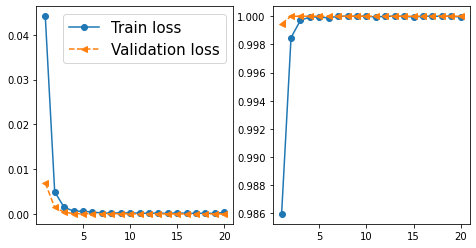

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 30 11:39:37 2020

@author: scholar1
"""
#from pyimagesearch.minivggnet import MiniVGGNet
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from imutils import build_montages
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
import sys

from mlxtend.plotting import plot_decision_regions
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 20
INIT_LR = 1e-2
BS = 32

def build_model(width, height, depth, classes):
	# initialize the model along with the input shape to be
	# "channels last" and the channels dimension itself
	model = tf.keras.models.Sequential()
	inputShape = (height, width, depth)
	chanDim = -1

	# if we are using "channels first", update the input shape
	# and channels dimension
	if K.image_data_format() == "channels_first":
		inputShape = (depth, height, width)
		chanDim = 1

	# first CONV => RELU => CONV => RELU => POOL layer set
	model.add(tf.keras.layers.Conv2D(20, (5, 5), padding="valid", activation="relu", input_shape=inputShape))
	model.add(tf.keras.layers.BatchNormalization(axis=chanDim))
	model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
	model.add(tf.keras.layers.Conv2D(50, (5, 5), padding="valid", activation="relu"))
	model.add(tf.keras.layers.BatchNormalization(axis=chanDim))
	model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

	# first (and only) set of FC => RELU layers
	model.add(tf.keras.layers.Flatten())
	model.add(tf.keras.layers.Dense(500, activation="relu"))
	model.add(tf.keras.layers.BatchNormalization())
	
	# softmax classifier
	model.add(tf.keras.layers.Dense(classes, activation="softmax"))

	# return the constructed network architecture
	return model


def get_all_images_for_label(label, X, Y):	
	img_paths = glob.glob(os.path.join("/content/drive/MyDrive/video1/training", label, "*.png"))
	for img_path in img_paths:
		X.append(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))
	if label != "background":
		Y.extend(int(label) for i in range(len(img_paths)))

	else:
		Y.extend(4 for i in range(len(img_paths)))
#data_dir = "video1/"
#annotation_3d_points = np.array(read_point_file(os.path.join(data_dir, "markers3dPoints.txt")))

X = []
Y = []

get_all_images_for_label("0", X, Y)
get_all_images_for_label("1", X, Y)
get_all_images_for_label("2", X, Y)
get_all_images_for_label("3", X, Y)
get_all_images_for_label("background", X, Y)

# convert from python list to numpy array
X = np.array(X)
Y = np.array(Y) 

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.1, shuffle= True)

print("trainX.shape", trainX.shape)
print("trainY.shape", trainY.shape)
print("testX.shape", testX.shape) 
print("testY.shape", testY.shape) 

img_width = trainX[0].shape[1]
img_height = trainX[0].shape[0]


# if we are using "channels first" ordering, then reshape the design
# matrix such that the matrix is:
# 	num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	trainX = trainX.reshape((trainX.shape[0], 1, img_width, img_height))
	testX = testX.reshape((testX.shape[0], 1, img_width, img_height))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	trainX = trainX.reshape((trainX.shape[0], img_width, img_height, 1))
	testX = testX.reshape((testX.shape[0], img_width, img_height, 1))
 
# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

num_classes = 5

# one-hot encode the training and testing labels
trainY = tf.keras.utils.to_categorical(trainY, num_classes)
testY = tf.keras.utils.to_categorical(testY, num_classes)

labelNames = ["0 ", "1", "2", "3", "background"]




# initialize the optimizer and model
print("[INFO] compiling model...")
opt = tf.keras.optimizers.SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model = build_model(width=img_width, height=img_height, depth=1, classes=num_classes)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print(model.summary())

# train the network
print("[INFO] training model...")
H = model.fit(trainX, trainY,
	validation_data=(testX, testY),
	batch_size=BS, epochs=NUM_EPOCHS)

model.save('model_part_detection.h5')  # creates a HDF5 file 'my_model.h5'

hist = H.history
x_arr = np.arange(len(hist['loss'])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend (fontsize=15)
ax = fig.add_subplot(1, 3, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<',
        label='Validation acc.')
#ax.legend(fontsize=15)
#ax = fig.add_subplot(1, 3, 3)
#plot_decision_regions(X= testX, clf=model)
#ax.set_xlabel(r'$x_1$', size=15)
#ax.xaxis.set_label.coords(1, -0.025)
#ax.set_ylabel(r'$x_2$', size=15)
#ax.yaxis.set_label.coords(-0.025, 1)
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


(1715, 64, 64) (1715, 12)
trainX.shape (1543, 64, 64)
trainY.shape (1543, 12)
testX.shape (172, 64, 64)
testY.shape (172, 12)
[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 60, 60, 20)        520       
                                                                 
 batch_normalization_3 (Batc  (None, 60, 60, 20)       80        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 20)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 50)        25050     
                                                                 
 batch_normalization_4 (Batc  (None, 26, 26, 50)       200       
 hNormalization)                                                 
                                                      

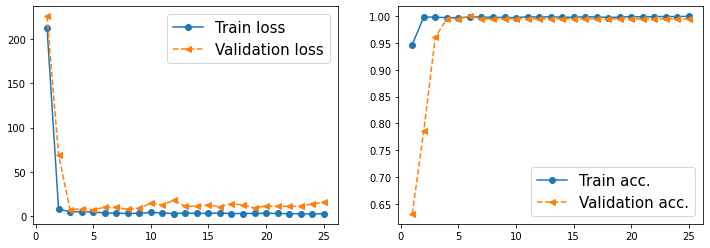

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 30 12:07:05 2020

@author: scholar1
"""
#from pyimagesearch.minivggnet import MiniVGGNet
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from imutils import build_montages
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
import pickle

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 25
INIT_LR = 1e-2
BS = 32

def build_model(width, height, depth, classes):
	# initialize the model along with the input shape to be
	# "channels last" and the channels dimension itself
	model = tf.keras.models.Sequential()
	inputShape = (height, width, depth)
	chanDim = -1

	# if we are using "channels first", update the input shape
	# and channels dimension
	if K.image_data_format() == "channels_first":
		inputShape = (depth, height, width)
		chanDim = 1

	# first CONV => RELU => CONV => RELU => POOL layer set
	model.add(tf.keras.layers.Conv2D(20, (5, 5), padding="valid", activation="relu", input_shape=inputShape))
	model.add(tf.keras.layers.BatchNormalization(axis=chanDim))
	model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
	model.add(tf.keras.layers.Conv2D(50, (5, 5), padding="valid", activation="relu"))
	model.add(tf.keras.layers.BatchNormalization(axis=chanDim))
	model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

	# first (and only) set of FC => RELU layers
	model.add(tf.keras.layers.Flatten())
	model.add(tf.keras.layers.Dense(1024, activation="relu"))
	model.add(tf.keras.layers.BatchNormalization())
	
	# softmax classifier
	model.add(tf.keras.layers.Dense(classes, activation="linear"))

	# return the constructed network architecture
	return model


def get_all_images_for_label(label, X, Y):	
	img_paths = glob.glob(os.path.join("training", "64x64_" + label, "*.png"))
	for img_path in img_paths:
		X.append(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))
	#print("c")
	if label != "background":
		Y.extend(int(label) for i in range(len(img_paths)))
	else:
		Y.extend(4 for i in range(len(img_paths)))

num_parts = 4

for i in range(num_parts):
	X = []
	Y = []

	img_paths = sorted(glob.glob(os.path.join("/content/drive/MyDrive/video1/training", "64x64_" + str(i), "*.png")))
	for img_path in img_paths:
		X.append(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))

	file_name = "/content/drive/MyDrive/video1/training/projected_control_points_" + str(i) + ".data"
	with open(file_name, 'rb') as filehandle:  
		Y = pickle.load(filehandle)

	# convert from python list to numpy array
	X = np.array(X)
	Y = np.array(Y) 

	num_control_points = Y.shape[1]
	# reshape control points in 1d vector
	Y = Y.reshape((Y.shape[0], num_control_points * 2))

	print(X.shape, Y.shape)
	trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.1, shuffle= True)

	print("trainX.shape", trainX.shape)
	print("trainY.shape", trainY.shape)
	print("testX.shape", testX.shape) 
	print("testY.shape", testY.shape) 

	img_width = trainX[0].shape[1]
	img_height = trainX[0].shape[0]

	# if we are using "channels first" ordering, then reshape the design
	# matrix such that the matrix is:
	# 	num_samples x depth x rows x columns
	if K.image_data_format() == "channels_first":
		trainX = trainX.reshape((trainX.shape[0], 1, img_width, img_height))
		testX = testX.reshape((testX.shape[0], 1, img_width, img_height))
	
	# otherwise, we are using "channels last" ordering, so the design
	# matrix shape should be: num_samples x rows x columns x depth
	else:
		trainX = trainX.reshape((trainX.shape[0], img_width, img_height, 1))
		testX = testX.reshape((testX.shape[0], img_width, img_height, 1))
	
	# scale data to the range of [0, 1]
	trainX = trainX.astype("float32") / 255.0
	testX = testX.astype("float32") / 255.0

	# initialize the optimizer and model
	print("[INFO] compiling model...")
	opt = tf.keras.optimizers.SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
	model = build_model(width=img_width, height=img_height, depth=1, classes=num_control_points * 2)
	model.compile(loss="mean_squared_error", optimizer=opt,
		metrics=["accuracy"])

	print(model.summary())

	# train the network
	print("[INFO] training model...")
	H = model.fit(trainX, trainY,
		validation_data=(testX, testY),
		batch_size=BS, epochs=NUM_EPOCHS)

	model.save("model_control_points_" + str(i) + ".h5")  # creates a HDF5 file 'my_model.h5'
hist = H.history
x_arr = np.arange(len(hist['loss'])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend (fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<',
        label='Validation acc.')
ax.legend(fontsize=15)
plt.show()

In [ ]:
0# -*- coding: utf-8 -*-
"""
Created on Mon Nov 30 12:09:46 2020

@author: scholar1
"""
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
#from pyimagesearch.minivggnet import MiniVGGNet
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import backend as K
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob 
!pip install pywavefront
#!apt-get install PyWavwfront
import pywavefront
import sys

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

def read_point_file(file_path):
	points = []
	with open(file_path) as f:
		content = f.readlines()

		for line in content:
			elements = line.split()
			points.append([float(x) for x in elements])

	return points

def get_3d_control_points_coord_for_all_parts(data_dir):
	annotation_3d_points = np.array(read_point_file(os.path.join(path_to_data, "markers3dPoints.txt")))

	# extract only 4 representative parts
	annotation_3d_points = np.delete(annotation_3d_points, [1, 3, 5, 7], 0)
	assert annotation_3d_points.shape == (16, 3)

	control_point_offset = np.array([[0.05, 0, 0], [-0.05, 0, 0], [0, 0.05, 0], [0, -0.05, 0], [0, 0, 0.05], [0, 0, -0.05]])

	control_points_for_all_parts = []
	for annotation_pt in annotation_3d_points:
		control_pts_for_part = []
		for offset in control_point_offset:
			control_pts_for_part.append(annotation_pt + offset)

		control_points_for_all_parts.append(control_pts_for_part)

	control_points_for_all_parts = np.array(control_points_for_all_parts)
	#assert control_points_for_all_parts.shape == (4, 6, 3)

	return control_points_for_all_parts

def difference_of_Gaussians(img):
	kernel1 = cv2.getGaussianKernel(10, 1)
	kernel2 = cv2.getGaussianKernel(10, 3)

	dog_img = cv2.sepFilter2D(img, -1, kernel1 - kernel2, kernel1 - kernel2)
	dog_img = cv2.normalize(dog_img, dog_img, alpha = 0, beta = 255, norm_type=cv2.NORM_MINMAX)

	return dog_img

def get_cropped_image(x, y, img):
	x_min = x - 16
	x_max = x + 16
	y_min = y - 16
	y_max = y + 16
	if x_min < 0 or x_max >= np.size(img,1) or y_min < 0 or y_max >= np.size(img,0):
		return np.empty(0)

	# crop = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)[y_min:y_max, x_min:x_max]
	crop = difference_of_Gaussians(img[y_min:y_max, x_min:x_max]) # this was changed! check the latest extract_parts.py

	return crop

labelNames = ["0", "1", "2", "3", "background"]

data_dir = "/content/drive/MyDrive/video1/training/"


mesh = pywavefront.Wavefront(os.path.join("/content/drive/MyDrive/video1/openbox.obj"))

for name, material in mesh.materials.items():
 	triangles = material.vertices

triangles = np.array(triangles)
triangles = triangles.reshape(-1, 3)

#test from training data
path_to_data = "/content/drive/MyDrive/video1test/"


control_points_for_all_parts = get_3d_control_points_coord_for_all_parts(data_dir)

#path_to_data = os.path.join(data_dir, "3D Rigid Tracking from RGB Images Dataset/BOX-TestAndInfo/Test/video1")



num_input_files = len(glob.glob(os.path.join(path_to_data,"*.png")))

camera_matrix = np.float32([[2666.67, 0, 960], [0, 2666.67, 540], [0, 0, 1.]])

model = tf.keras.models.load_model('model_part_detection.h5')

model_for_control_points = []

for part_id in range(4):
	model_for_control_points.append(tf.keras.models.load_model("model_control_points_" + str(part_id) + ".h5"))

n = 0

while True:
	print("Pose estimation:" + str(n))
	testX = []
	test_locations = []

	file_name = "frame" + str(n).zfill(5) + ".png"
	img_path = os.path.join(path_to_data, file_name)
	img = cv2.imread(img_path)
	img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    
     
	# scale image by the same ratio when generating training data
	scale_ratio = 0.25
	inv_scale_ratio = 1.0 / scale_ratio

	img = cv2.resize(img, None, fx=scale_ratio, fy=scale_ratio, interpolation=cv2.INTER_AREA)

	normalize = 1.0 / 255
	step = 2

	for y in range(16, img.shape[0]-16, step):
		for x in range(16, img.shape[1]-16, step):
			cropped = get_cropped_image(x, y, img)
			if cropped.shape == 0:
				continue;
				
			# scale data to the range of [0, 1]
			cropped = cropped.astype("float32") * normalize # normalize outside of loop!

			testX.append(cropped)
			test_locations.append((x, y))

	print("data ready")

	test_locations_width = int((img.shape[1] - 32) / step)
	test_locations_height = int((img.shape[0] - 32) / step)

	# convert from python list to numpy array
	testX = np.array(testX)

	if K.image_data_format() == "channels_first":
		testX = testX.reshape((testX.shape[0], 1, 32, 32))
	else:
		testX = testX.reshape((testX.shape[0], 32, 32, 1))

	print("testX.shape", testX.shape)

	# use 1st CNN to a set of 32x32 patches
	#probs[i]: probability of i-th patch, which part the patch is?
	probs = model.predict(testX)

	test_locations_probs = probs.reshape(test_locations_height, test_locations_width, probs.shape[1])

	to_test_location = lambda coord : coord * step + np.array([16, 16])
                    
	label_color = [ (0,0,255), (0,255,0), (255,0,0), (0,255,255), ]
	color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

	part_probability = []
	object_points_for_pose_estimation = []
	image_points_for_pose_estimation = []

	# apply each 2nd CNN to a set of 64x64 patches
	for part_id in range(4):
		test_locations_probs_for_part = test_locations_probs[:,:,part_id]

		retval, high_probs_locations = cv2.threshold(test_locations_probs_for_part, 0.99, 255, cv2.THRESH_BINARY)
		high_probs_locations = high_probs_locations.astype("ubyte")

		retval, labels, stats, centroids = cv2.connectedComponentsWithStats(high_probs_locations, connectivity=8)

		kMinRequiredArea = 3
		part_location_candidates = []

		for label in range(1, stats.shape[0]):
			area = stats[label, cv2.CC_STAT_AREA]
			centorid = np.array([int(centroids[label, 0]), int(centroids[label, 1])])

			part_location_candidates.append((to_test_location(centorid), area))
		
		part_location_candidates.sort(key=lambda candidate: candidate[1], reverse = True)

		if part_location_candidates and part_location_candidates[0][1] >= kMinRequiredArea:
			location = part_location_candidates[0][0]
			cv2.circle(color_img, tuple(location), 10, label_color[part_id], 1)

			x_min = location[0] - 32
			x_max = location[0] + 32
			y_min = location[1] - 32
			y_max = location[1] + 32
			if x_min < 0 or x_max >= np.size(img,1) or y_min < 0 or y_max >= np.size(img,0):
				continue

			crop_for_control_points = img[y_min:y_max, x_min:x_max]

			# scale data to the range of [0, 1]
			crop_for_control_points = crop_for_control_points.astype("float32") * normalize # normalize outside of loop!

			# convert from python list to numpy array
			testX = np.array([crop_for_control_points])

			if K.image_data_format() == "channels_first":
				testX = testX.reshape((testX.shape[0], 1, 64, 64))
			else:
				testX = testX.reshape((testX.shape[0], 64, 64, 1))

			print("testX.shape", testX.shape)

			# use 2nd CNN to estimate pose of the control part
			control_points_offset = model_for_control_points[part_id].predict(testX)
			control_points_offset = control_points_offset.reshape(6, 1, 2)

			ctrl_pt_color = [ (0,0,255), (0,0,255), (0,255,0), (0,255,0), (255,0,0), (255,0,0) ]

			if True: # visualize control points
				for idx, offset in enumerate(control_points_offset):
					projected_control_points = location + offset * 0.25 #32 + offset * 0.25
					cv2.circle(color_img, (int(projected_control_points[0][0]), int(projected_control_points[0][1])), 3, ctrl_pt_color[idx], -1)

			object_points_for_pose_estimation.append(control_points_for_all_parts[part_id])
			image_points_for_pose_estimation.append(location * inv_scale_ratio + control_points_offset)

	# compute object pose
	if object_points_for_pose_estimation and image_points_for_pose_estimation:

		object_points_for_pose_estimation = np.array(object_points_for_pose_estimation).reshape(-1, 3)
		image_points_for_pose_estimation = np.array(image_points_for_pose_estimation).reshape(-1, 2)
        
        # output on values to be researched 
		retval, rvec, tvec, inliers	= cv2.solvePnPRansac(object_points_for_pose_estimation, image_points_for_pose_estimation, camera_matrix, np.empty(0))
		#print(retval)
		print(rvec)
		print(tvec)
		#print(inliers)

		to_tuple = lambda p : (int(p[0][0] * scale_ratio), int(p[0][1] * scale_ratio))
        
        #search what it means
		projected_triangle_points, jac = cv2.projectPoints(triangles, rvec, tvec, camera_matrix, np.empty(0))
		for j in range(0, projected_triangle_points.shape[0], 3):
 			cv2.line(color_img, to_tuple(projected_triangle_points[j]), to_tuple(projected_triangle_points[j+1]), (255, 255, 100))
 			cv2.line(color_img, to_tuple(projected_triangle_points[j+1]), to_tuple(projected_triangle_points[j+2]), (255, 255, 100))
 			cv2.line(color_img, to_tuple(projected_triangle_points[j+2]), to_tuple(projected_triangle_points[j]), (255, 255, 100))

	cv2.putText(color_img, str(n), (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

	print("done")

	if True: # write images for video
		print(color_img.shape)
        # image outputs tracking
		cv2.imwrite("/content/drive/MyDrive/output/Pose estimation" + str(n) + ".jpg", color_img)
		print(str(n) + " / " + str(num_input_files))
		n = n + 1
		if n == num_input_files:
			sys.exit(1)
		continue

	cv2.imshow("Pose estimation", color_img)
	key = cv2.waitKey(1)

	print("key", key)

	if key == 27:         # wait for ESC key to exit
		cv2.destroyAllWindows()
		sys.exit(0)
	elif key == 81: # left arrow
		n = max(n - 1, 0)
	elif key == 82: # up arrow
		n = n + 5
	elif key == 84: # down arrow
		n = n - 5
	else:
		n = n + 1


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
Unimplemented OBJ format statement 'g' on line 'g group1'


Pose estimation:0
data ready
testX.shape (26656, 32, 32, 1)
testX.shape (1, 64, 64, 1)
[[ 2.71656116]
 [ 0.01246397]
 [-0.05078194]]
[[-0.10306378]
 [ 0.14260858]
 [ 1.21016429]]
done
(270, 480, 3)
0 / 201
Pose estimation:1
data ready
testX.shape (26656, 32, 32, 1)
testX.shape (1, 64, 64, 1)
[[ 2.71287415]
 [ 0.0029823 ]
 [-0.06775319]]
[[-0.10321784]
 [ 0.14464516]
 [ 1.20582698]]
done
(270, 480, 3)
1 / 201
Pose estimation:2
data ready
testX.shape (26656, 32, 32, 1)
testX.shape (1, 64, 64, 1)
[[ 2.70816397e+00]
 [ 4.21291464e-04]
 [-7.73437918e-02]]
[[-0.10390385]
 [ 0.14408975]
 [ 1.20568615]]
done
(270, 480, 3)
2 / 201
Pose estimation:3
data ready
testX.shape (26656, 32, 32, 1)
done
(270, 480, 3)
3 / 201
Pose estimation:4
data ready
testX.shape (26656, 32, 32, 1)
done
(270, 480, 3)
4 / 201
Pose estimation:5
data ready
testX.shape (26656, 32, 32, 1)
done
(270, 480, 3)
5 / 201
Pose estimation:6
data ready
testX.shape (26656, 32, 32, 1)
done
(270, 480, 3)
6 / 201
Pose estimation:7
data

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
